In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import StandardScaler
import mglearn

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

### 군집 알고리즘 비교와 평가

#### 타겟값으로 군집 평가

ARI / NMI : 최적의 값을 가질 때 1이라는 값을 가지고, 군집이 잘 분류되지 않고 무작위로 생성되었을 때 0이라는 값을 가짐 / 0~1 사이의 값을 가짐

** ARI는 음수가 될 수도 있음

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
x, y = make_moons(n_samples=200, noise=0.05, random_state=0)

In [8]:
# StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)

In [9]:
# 사용할 알고리즘 모델을 리스트로 만듦
al = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

In [11]:
# 비교를 위해 무작위로 믈러스터 할당
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(x))

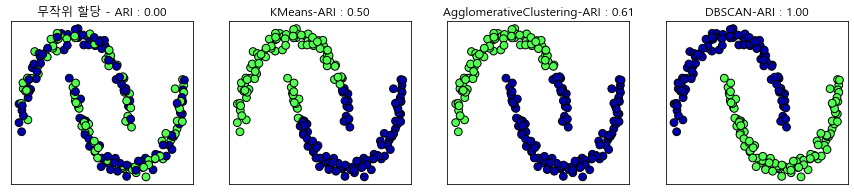

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(15,3), subplot_kw={'xticks':(), 'yticks':()})

# 무작위로 할당한 클러스터 그리기
axes[0].scatter(x_scaled[:,0], x_scaled[:,1], c=random_clusters, cmap=mglearn.cm3, s=60, edgecolors='black')
axes[0].set_title('무작위 할당 - ARI : {:.2f}'.format(adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], al) :
    
    clusters = algorithm.fit_predict(x_scaled)
    ax.scatter(x_scaled[:,0], x_scaled[:,1], c=clusters, cmap=mglearn.cm3, s=60, edgecolors='black')
    ax.set_title('{}-ARI : {:.2f}'.format(algorithm.__class__.__name__, adjusted_rand_score(y,clusters)))

In [16]:
from sklearn.metrics import accuracy_score

In [18]:
cluster1 = [0,0,1,1,0]
cluster2 = [1,1,0,0,1]

print('정확도 : {:.2f}'.format(accuracy_score(cluster1, cluster2)))
print('ARI : {:.2f}'.format(adjusted_rand_score(cluster1, cluster2)))

정확도 : 0.00
ARI : 1.00


군집에서는 accuracy를 사용하면 안됨

### 실루엣 지수
- 그렇게 잘 작동하는 지표는 아님
- 클러스터의 밀접정도를 계산해줘서 값이 높을수록 좋고 최대점수 1을 가짐
- 복잡할 때 밀집도를 활용한 평가는 잘 맞지않음
- 1과 -1 사이의 값을 가짐
- -1일 때는 군집을 잘못 분류, 0일 때는 군집 중첩, 1일 때는 군집이 잘 분류됨

In [23]:
from sklearn.metrics.cluster import silhouette_score

In [24]:
x, y = make_moons(n_samples=200, noise=0.05, random_state=0)

In [25]:
scaler = StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)

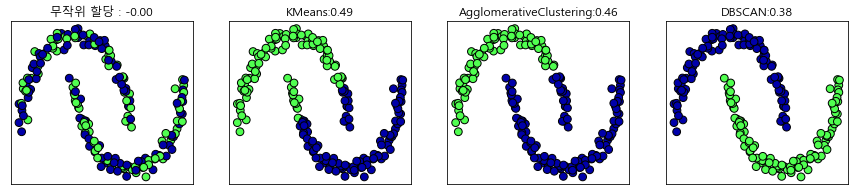

In [27]:
fig, axes = plt.subplots(1,4, figsize=(15,3), subplot_kw = {'xticks':(), 'yticks':()})

random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(x))

axes[0].scatter(x_scaled[:,0], x_scaled[:,1], c=random_clusters, cmap=mglearn.cm3, s=60, edgecolors='black')
axes[0].set_title('무작위 할당 : {:.2f}'.format(silhouette_score(x_scaled, random_clusters)))

al = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

for ax, algorithm in zip(axes[1:], al):
    clusters = algorithm.fit_predict(x_scaled)
    ax.scatter(x_scaled[:,0], x_scaled[:,1], c=clusters, cmap=mglearn.cm3, s=60, edgecolors='black')
    ax.set_title('{}:{:.2f}'.format(algorithm.__class__.__name__, silhouette_score(x_scaled, clusters)))

실루엣 계수가 높다고 하더라도 유의미하다라고 확정적으로 판단할 수는 없다

#### 얼굴 데이터셋으로 군집 알고리즘 비교

In [28]:
from sklearn.datasets import fetch_lfw_people

In [31]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target==target)[0][:50]] = 1
    
x_people = people.data[mask]
y_people = people.target[mask]

x_people = x_people / 255.

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0)
x_pca = pca.fit_transform(x_people)

#### DBSCAN

In [34]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(x_pca)
print('고유한 레이블 : ', np.unique(labels))

고유한 레이블 :  [-1]


In [35]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(x_pca)
print('고유한 레이블 :', np.unique(labels)) # 노이즈 데이터 생김

고유한 레이블 : [-1  0]


In [36]:
print('클러스터별 포인트 수 :', np.bincount(labels + 1))
# 노이즈 데이터가 32개 생겼다

클러스터별 포인트 수 : [  32 2031]


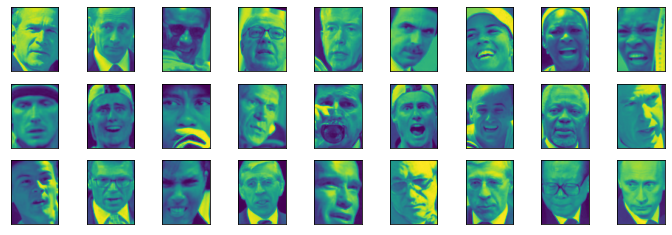

In [37]:
noise = x_people[labels==-1]

fig, axes = plt.subplots(3, 9, subplot_kw={'xticks':(), 'yticks':()}, figsize=(12,4))

for image, ax in zip(noise, axes.ravel()) :
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

In [38]:
for eps in [1,3,5,7,9,11,13]: #eps 값에 따른 클러스터 수와 크기 변화
    print('\neps=', eps)
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(x_pca)
    print('클러스터 수 :', len(np.unique(labels)))
    print('클러스터 크기 :', np.bincount(labels+1))


eps= 1
클러스터 수 : 1
클러스터 크기 : [2063]

eps= 3
클러스터 수 : 1
클러스터 크기 : [2063]

eps= 5
클러스터 수 : 1
클러스터 크기 : [2063]

eps= 7
클러스터 수 : 14
클러스터 크기 : [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps= 9
클러스터 수 : 4
클러스터 크기 : [1307  750    3    3]

eps= 11
클러스터 수 : 2
클러스터 크기 : [ 413 1650]

eps= 13
클러스터 수 : 2
클러스터 크기 : [ 120 1943]


이상치 검출

### K-Means

In [40]:
n_clusters = 10

km = KMeans(n_clusters = n_clusters, random_state=0)
labels_km = km.fit_predict(x_pca)
print('k-means 클러스터 크기 :', np.bincount(labels_km))

k-means 클러스터 크기 : [155 175 238  75 358 257  91 219 323 172]


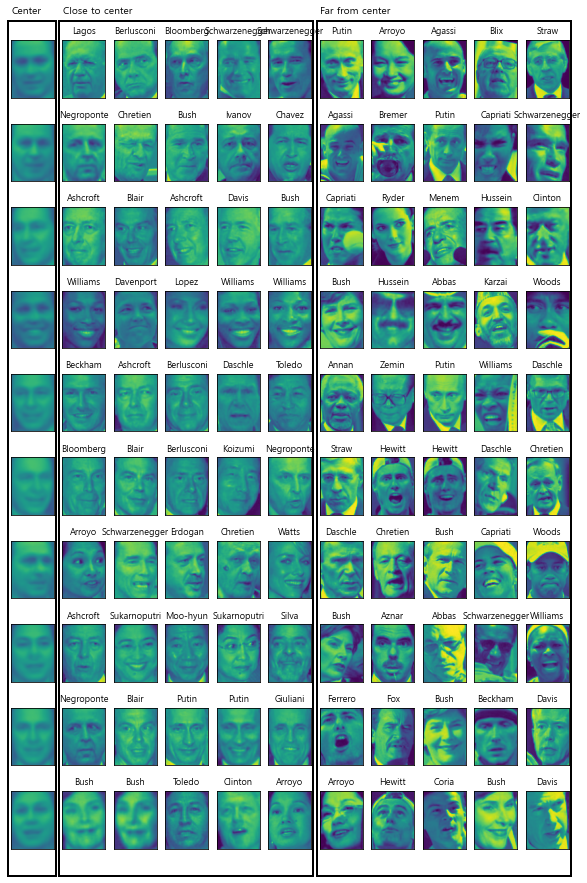

In [41]:
mglearn.plots.plot_kmeans_faces(km, pca, x_pca, x_people, y_people, people.target_names)

### 계층적 군집으로 얼굴 분석

In [43]:
agg = AgglomerativeClustering(n_clusters=10)
labels_agg = agg.fit_predict(x_pca)

print('군집의 클러스터 크기 :', np.bincount(labels_agg))

군집의 클러스터 크기 : [169 660 144 329 217  85  18 261  31 149]


In [45]:
print('ARI : {:.2f}'.format(adjusted_rand_score(labels_agg, labels_km)))

ARI : 0.09


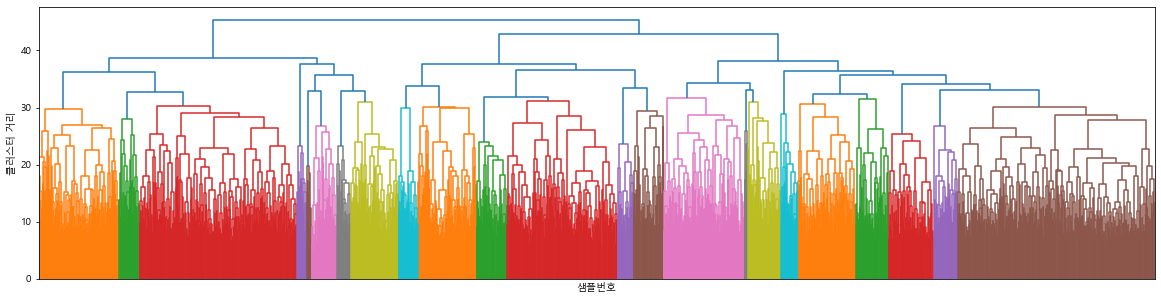

In [46]:
linkage_array = ward(x_pca) #클러스터 사이의 거리가 담겨져있음

plt.figure(figsize=(20,5))
dendrogram(linkage_array, p=7, no_labels=True)
plt.xlabel('샘플번호')
plt.ylabel('클러스터 거리')
plt.show()

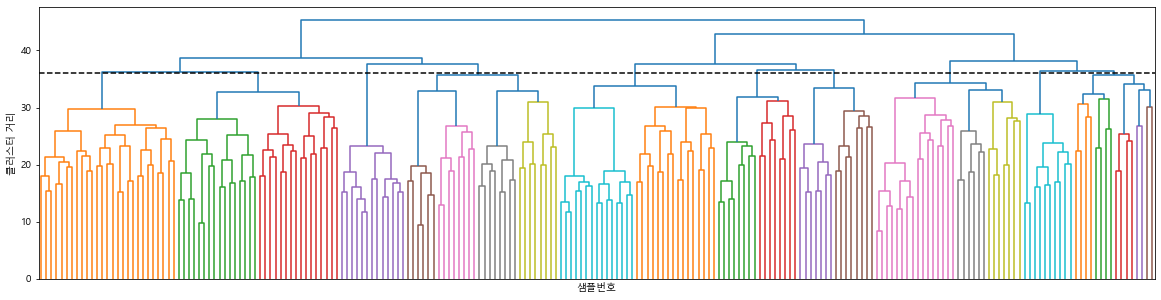

In [48]:
linkage_array = ward(x_pca) #위 그래프를 좀더 보기 편하게

plt.figure(figsize=(20,5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel('샘플번호')
plt.ylabel('클러스터 거리')

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [36,36], '--', c='k')